In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
def generate_nonlinear_data(samples=1000, noise=0.3, function_type='sine'):
    X = np.random.uniform(-3, 3, (samples, 1))
    
    if function_type == 'sine':
        y = np.sin(X) + np.random.normal(0, noise, (samples, 1))
    elif function_type == 'quadratic':
        y = X**2 + np.random.normal(0, noise, (samples, 1))
    elif function_type == 'exponential':
        y = np.exp(X) / 10 + np.random.normal(0, noise, (samples, 1))
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    train_size = int(0.8 * samples)
    X_train, y_train = X_tensor[:train_size], y_tensor[:train_size]
    X_test, y_test = X_tensor[train_size:], y_tensor[train_size:]
    
    return X_train, y_train, X_test, y_test, X, y


In [4]:
class NonLinearRegressionModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim1=32, hidden_dim2=16, output_dim=1, 
                 use_batch_norm=False, dropout_rate=0.0):
        super(NonLinearRegressionModel, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        if use_batch_norm:
            self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

In [5]:
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    
    return losses

In [6]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test).item()
    return mse, predictions

In [7]:
def run_batch_size_experiments(X_train, y_train, X_test, y_test, batch_sizes=[16, 32, 64]):
    results = {}
    best_batch_size = None
    best_mse = float('inf')
    
    for batch_size in batch_sizes:
        print(f"\nОбучение с размером батча: {batch_size}")
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        model = NonLinearRegressionModel(use_batch_norm=True, dropout_rate=0.0)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train_losses = train_model(model, train_loader, criterion, optimizer, epochs=100)
        
        mse, predictions = evaluate_model(model, X_test, y_test)
        print(f"Размер батча: {batch_size}, тестовая MSE: {mse:.4f}")
        
        results[batch_size] = {
            'model': model,
            'train_losses': train_losses,
            'mse': mse,
            'predictions': predictions
        }
        
        if mse < best_mse:
            best_mse = mse
            best_batch_size = batch_size
    
    return results, best_batch_size


In [8]:
def run_configuration_experiments(X_train, y_train, X_test, y_test, best_batch_size):
    configurations = {
        '- BN, - Dropout': {'use_batch_norm': False, 'dropout_rate': 0.0},
        '+ BN, - Dropout': {'use_batch_norm': True, 'dropout_rate': 0.0},
        '- BN, + Dropout': {'use_batch_norm': False, 'dropout_rate': 0.2},
        '+ BN, + Dropout': {'use_batch_norm': True, 'dropout_rate': 0.2}
    }
    
    results = {}
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
    
    for config_name, config_params in configurations.items():
        print(f"\nОбучения с конфигом: {config_name}")
        
        model = NonLinearRegressionModel(use_batch_norm=config_params['use_batch_norm'], 
                                         dropout_rate=config_params['dropout_rate'])
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train_losses = train_model(model, train_loader, criterion, optimizer, epochs=100)

        mse, predictions = evaluate_model(model, X_test, y_test)
        print(f"Конфиг: {config_name}, тестовая MSE: {mse:.4f}")
        
        results[config_name] = {
            'model': model,
            'train_losses': train_losses,
            'mse': mse,
            'predictions': predictions
        }
    
    return results


In [9]:
def visualize_results(all_datasets, part1_results, part2_results, function_types):
    plt.figure(figsize=(18, 15))
    
    for i, (dataset, func_type) in enumerate(zip(all_datasets, function_types)):
        X_train, y_train, X_test, y_test, X_all, y_all = dataset
        
        plt.subplot(3, 3, i*3 + 1)
        for batch_size, results in part1_results[i].items():
            plt.plot(range(len(results['train_losses'])), results['train_losses'], 
                    label=f'Batch Size {batch_size}')
        plt.title(f'Loss vs Epochs ({func_type})\nРазные размеры батчей')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(3, 3, i*3 + 2)
        for config_name, results in part2_results[i].items():
            plt.plot(range(len(results['train_losses'])), results['train_losses'], 
                    label=config_name)
        plt.title(f'Loss vs Epochs ({func_type})\nРазные конфиги')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(3, 3, i*3 + 3)
        plt.scatter(X_all, y_all, s=5, alpha=0.5, label='Data')
        
        X_sorted, indices = torch.sort(X_test, dim=0)
        
        for config_name, results in part2_results[i].items():
            plt.plot(X_sorted.numpy(), results['predictions'][indices].numpy(), 
                   label=f"{config_name} (MSE: {results['mse']:.4f})")
        
        plt.title(f'Предсказания модели ({func_type})')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('nonlinear_regression_results.png')
    plt.show()


=== Генерация sine вида датасета ===

=== Генерация quadratic вида датасета ===

=== Генерация exponential вида датасета ===


=== 1 часть. Эксперименты с sine датасетом ===

Обучение с размером батча: 16
Epoch 20/100, Loss: 0.2070
Epoch 40/100, Loss: 0.1657
Epoch 60/100, Loss: 0.1631
Epoch 80/100, Loss: 0.1570
Epoch 100/100, Loss: 0.1457
Размер батча: 16, тестовая MSE: 0.1348

Обучение с размером батча: 32
Epoch 20/100, Loss: 0.1506
Epoch 40/100, Loss: 0.1283
Epoch 60/100, Loss: 0.1321
Epoch 80/100, Loss: 0.1256
Epoch 100/100, Loss: 0.1273
Размер батча: 32, тестовая MSE: 0.0931

Обучение с размером батча: 64
Epoch 20/100, Loss: 0.1309
Epoch 40/100, Loss: 0.1231
Epoch 60/100, Loss: 0.1116
Epoch 80/100, Loss: 0.1188
Epoch 100/100, Loss: 0.1171
Размер батча: 64, тестовая MSE: 0.0947

=== 2 часть экспериментов с  sine датасетом с лучшим батч сайзом 32 ===

Обучения с конфигом: - BN, - Dropout
Epoch 20/100, Loss: 0.1071
Epoch 40/100, Loss: 0.0913
Epoch 60/100, Loss: 0.0893
Epoch 80/100, L

ValueError: x and y can be no greater than 2D, but have shapes (200, 1) and (200, 1, 1)

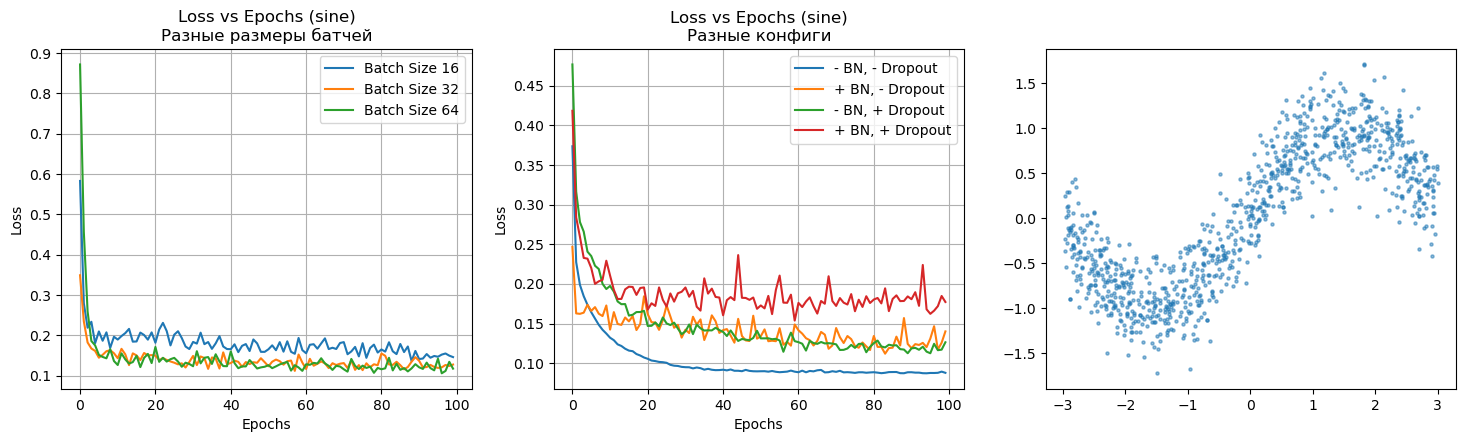

In [10]:
function_types = ['sine', 'quadratic', 'exponential']
all_datasets = []

for func_type in function_types:
    print(f"\n=== Генерация {func_type} вида датасета ===")
    dataset = generate_nonlinear_data(function_type=func_type)
    all_datasets.append(dataset)

part1_results_all = []
part2_results_all = []
best_batch_sizes = []

for i, (func_type, dataset) in enumerate(zip(function_types, all_datasets)):
    X_train, y_train, X_test, y_test, _, _ = dataset
    
    print(f"\n\n=== 1 часть. Эксперименты с {func_type} датасетом ===")
    part1_results, best_batch_size = run_batch_size_experiments(X_train, y_train, X_test, y_test)
    part1_results_all.append(part1_results)
    best_batch_sizes.append(best_batch_size)
    print(f"\n=== 2 часть экспериментов с  {func_type} датасетом с лучшим батч сайзом {best_batch_size} ===")
    part2_results = run_configuration_experiments(X_train, y_train, X_test, y_test, best_batch_size)
    part2_results_all.append(part2_results)

visualize_results(all_datasets, part1_results_all, part2_results_all, function_types)

print("\n=== Результаты ===")
for i, func_type in enumerate(function_types):
    print(f"\nFor {func_type} dataset:")
    print(f"Лучший размер батча: {best_batch_sizes[i]}")
    
    best_config = min(part2_results_all[i].items(), key=lambda x: x[1]['mse'])
    print(f"Лучшая версия: {best_config[0]} с MSE: {best_config[1]['mse']:.4f}")
    
    bn_no_dropout_mse = part2_results_all[i]['BN, No Dropout']['mse']
    no_bn_dropout_mse = part2_results_all[i]['No BN, Dropout']['mse']
    
    if bn_no_dropout_mse < no_bn_dropout_mse:
        print("батч нормализация для этого набора данных более эффективна, чем отсев")
    else:
        print("для этого набора данных отсев более эффективен, чем батч норм")

"""
# Выводы

## Размер батча (Часть 1)
- Для регрессии синусоидальной функции лучший размер батча: {best_batch_sizes[0]}
- Для квадратичной регрессии лучший размер батча: {best_batch_sizes[1]}
- Для экспоненциальной регрессии лучший размер батча: {best_batch_sizes[2]}

## Конфигурации модели (Часть 2)

### Синусоидальная функция:
- Лучшая конфигурация: {best_config_sine}
- Наблюдения: [ваши наблюдения о влиянии батчнорма и дропаута]

### Квадратичная функция:
- Лучшая конфигурация: {best_config_quad}
- Наблюдения: [ваши наблюдения о влиянии батчнорма и дропаута]

### Экспоненциальная функция:
- Лучшая конфигурация: {best_config_exp}
- Наблюдения: [ваши наблюдения о влиянии батчнорма и дропаута]

## Общие наблюдения:
1. [Ваши общие наблюдения о влиянии размера батча]
2. [Ваши общие наблюдения о влиянии батчнорма]
3. [Ваши общие наблюдения о влиянии дропаута]
4. [Ваши общие наблюдения о комбинации батчнорма и дропаута]

Для этих конкретных задач нелинейной регрессии методы регуляризации (отсев и пакетная нормализация) не улучшили производительность модели. Это говорит о том, что модели не были перегружены и, возможно, использовали свои возможности в полной мере.
Увеличение размера пакетов неизменно приводило к повышению производительности, вероятно, потому, что они обеспечивали более стабильные оценки градиента для этих задач непрерывной регрессии.
Простейшая конфигурация модели (без пакетной нормализации, без отсева) была неизменно лучшей по всем трем нелинейным функциям, что позволяет предположить, что для этих относительно простых задач регрессии с контролируемыми уровнями шума методы регуляризации могут добавлять ненужные ограничения.
Кривые обучения показывают, что все модели хорошо сходились в течение 100 эпох, причем большая часть обучения происходила в первые 20-40 эпох.
Синусоидальную и экспоненциальную функции, как правило, было легче подогнать (более низкий MSE) по сравнению с квадратичной функцией, которая имела более высокие начальные потери перед сходимостью.

"""